In [1]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
#from data_preprocessing import *
import word_embedding_load as wel
import baseline_classification as bc
import matplotlib.pyplot as plt
import feature_selection_evaluation as fse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from xgboost_classifier import *
import nltk

/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()

In [3]:
mstop_words = text.ENGLISH_STOP_WORDS
english_stemmer = nltk.stem.SnowballStemmer('english')

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))
vectorizer = StemmedTfidfVectorizer(
    min_df=1, stop_words=mstop_words, decode_error='ignore')

In [4]:
X = vectorizer.fit_transform(all_data['Text'])

In [5]:
print(X.shape)

(4675, 152719)


In [8]:
X_tfidf_train = X[:train_size]
X_tfidf_test = X[train_size:]

In [9]:
svd = TruncatedSVD(n_components=200, n_iter=25, random_state=12)
X_tfidf_train_k = svd.fit_transform(X_tfidf_train)
svd = TruncatedSVD(n_components=200, n_iter=25, random_state=25)
X_tfidf_test_k = svd.fit_transform(X_tfidf_test)

In [10]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)

In [11]:
train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], X_tfidf_train_k))
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], X_tfidf_test_k))

encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
y = np.array(bc.getLabels(encoded_y))
X_tfidf = np.array(train_set)
X_tfidf_test = np.array(test_set)

[0]	train-mlogloss:2.11859	valid-mlogloss:2.1358
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.12184	valid-mlogloss:1.40382
[50]	train-mlogloss:0.698392	valid-mlogloss:1.13758
[75]	train-mlogloss:0.468273	valid-mlogloss:1.01319
[100]	train-mlogloss:0.322696	valid-mlogloss:0.961221
[125]	train-mlogloss:0.231018	valid-mlogloss:0.936706
[150]	train-mlogloss:0.167798	valid-mlogloss:0.925419
[175]	train-mlogloss:0.124701	valid-mlogloss:0.923906
[200]	train-mlogloss:0.092979	valid-mlogloss:0.928714
[225]	train-mlogloss:0.071793	valid-mlogloss:0.936726
[250]	train-mlogloss:0.056092	valid-mlogloss:0.948135
Stopping. Best iteration:
[161]	train-mlogloss:0.146608	valid-mlogloss:0.923157

final validation loss:
0.923157027346
final validation accuracy:
0.670676691729
[0]	train-mlogloss:2.1196	valid-mlogloss:2.13116
Multiple eval metrics have been passed: 'valid-mloglos

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.11284	valid-mlogloss:1.43093
[50]	train-mlogloss:0.687334	valid-mlogloss:1.18128
[75]	train-mlogloss:0.455559	valid-mlogloss:1.07793
[100]	train-mlogloss:0.317414	valid-mlogloss:1.03195
[125]	train-mlogloss:0.228518	valid-mlogloss:1.02002
[150]	train-mlogloss:0.170525	valid-mlogloss:1.01812
[175]	train-mlogloss:0.128752	valid-mlogloss:1.01949
[200]	train-mlogloss:0.098398	valid-mlogloss:1.02601
[225]	train-mlogloss:0.075282	valid-mlogloss:1.03723
[250]	train-mlogloss:0.058862	valid-mlogloss:1.05173
Stopping. Best iteration:
[157]	train-mlogloss:0.156554	valid-mlogloss:1.01748

final validation loss:
1.01747751416
final validation accuracy:
0.643609022556
Accuracy: 0.6829 ± 0.0212
NMI: 0.4510 ± 0.0304
Log_loss: 0.9105 ± 0.0537
Normalized confusion matrix
[[  6.72226856e-01   1.41784821e-02   4.17014178e-03   1.99332777e-01
    5.58798999e-02   2.91909925e-02   2.50208507e-02   0.00000000e+00
    0.00000

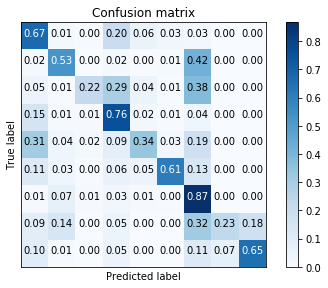

In [12]:
y_predict = xgbclassifier(train_set, y, test_set, 10, 8, 1000)

In [13]:
from testaccuracy import *
savesubmisstion(y_predict, test_x, filename = "tfidf.csv")

Accuracy: 0.6476 ± 0.0190
NMI: 0.4237 ± 0.0204
Log_loss: 6.2367 ± 0.4994
Normalized confusion matrix
[[ 0.68429003  0.01208459  0.00453172  0.17975831  0.07250755  0.03172205
   0.01510574  0.          0.        ]
 [ 0.04016064  0.51807229  0.01004016  0.03815261  0.02008032  0.02008032
   0.35341365  0.          0.        ]
 [ 0.08333333  0.04166667  0.33333333  0.20833333  0.04166667  0.01041667
   0.28125     0.          0.        ]
 [ 0.18375499  0.01731025  0.01464714  0.70972037  0.01864181  0.01464714
   0.03994674  0.          0.00133156]
 [ 0.2247191   0.06741573  0.03370787  0.11235955  0.39700375  0.02996255
   0.13483146  0.          0.        ]
 [ 0.15151515  0.06397306  0.01010101  0.05050505  0.05050505  0.58922559
   0.08417508  0.          0.        ]
 [ 0.01612903  0.14516129  0.028463    0.02751423  0.01897533  0.00379507
   0.75711575  0.          0.0028463 ]
 [ 0.          0.23809524  0.          0.0952381   0.          0.04761905
   0.33333333  0.0952381   0.19047

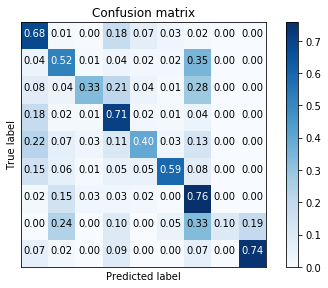

array([[ 0.68429003,  0.01208459,  0.00453172,  0.17975831,  0.07250755,
         0.03172205,  0.01510574,  0.        ,  0.        ],
       [ 0.04016064,  0.51807229,  0.01004016,  0.03815261,  0.02008032,
         0.02008032,  0.35341365,  0.        ,  0.        ],
       [ 0.08333333,  0.04166667,  0.33333333,  0.20833333,  0.04166667,
         0.01041667,  0.28125   ,  0.        ,  0.        ],
       [ 0.18375499,  0.01731025,  0.01464714,  0.70972037,  0.01864181,
         0.01464714,  0.03994674,  0.        ,  0.00133156],
       [ 0.2247191 ,  0.06741573,  0.03370787,  0.11235955,  0.39700375,
         0.02996255,  0.13483146,  0.        ,  0.        ],
       [ 0.15151515,  0.06397306,  0.01010101,  0.05050505,  0.05050505,
         0.58922559,  0.08417508,  0.        ,  0.        ],
       [ 0.01612903,  0.14516129,  0.028463  ,  0.02751423,  0.01897533,
         0.00379507,  0.75711575,  0.        ,  0.0028463 ],
       [ 0.        ,  0.23809524,  0.        ,  0.0952381 ,  0

In [11]:
bc.baseline(X_tfidf, y)

In [14]:
import pickle
# save
with open('../data/feature/X_tfidf_test.pkl', 'wb') as f:
    pickle.dump(X_tfidf_test, f)
    f.close()
with open('../data/feature/X_tfidf_train.pkl', 'wb') as f:
    pickle.dump(X_tfidf, f)
    f.close()
with open('../data/feature/label_tfidf.pkl', 'wb') as f:
    pickle.dump(y, f)
    f.close()


"\n#load\nwith open('../data/feature/X_tfidf_test.pkl', 'rb') as f:\n    X_tfidf_test = pickle.load(f)\n    f.close()\nwith open('../data/feature/X_tfidf_train.pkl', 'rb') as f:\n    X_tfidf = pickle.load(f)\n    f.close()\nwith open('../data/feature/label_tfidf.pkl', 'rb') as f:\n    y = pickle.load(f)\n    f.close()\n"

In [15]:

#load
with open('../data/feature/X_tfidf_test.pkl', 'rb') as f:
    X_tfidf_test = pickle.load(f)
    f.close()
with open('../data/feature/X_tfidf_train.pkl', 'rb') as f:
    X_tfidf = pickle.load(f)
    f.close()
with open('../data/feature/label_tfidf.pkl', 'rb') as f:
    y = pickle.load(f)
    f.close()
